In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from matplotlib.colors import ListedColormap

import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from statsmodels.tsa.arima.model import ARIMA



# Fetch Data

In [47]:
df = pd.read_csv('output_csv/2021-22_game_by_game.csv')
df.columns = df.columns.str.lower()

In [48]:
df.head()

,game_id,team_id,team_abbreviation,team_city,player_id,player_name,nickname,start_position,comment,min,...,oreb_pct,pace,pace_per40,pie,poss,reb_pct,tm_tov_pct,ts_pct,usg_pct,game_date
0,42000406,1610612756,PHX,Phoenix,1628969,Mikal Bridges,Mikal,F,NaN,39.000000:28,...,0.024,102.76,85.63,0.055,84,0.075,0.0,0.444,0.089,2021-07-20
1,42000406,1610612756,PHX,Phoenix,203109,Jae Crowder,Jae,F,NaN,40.000000:33,...,0.053,102.39,85.33,0.140,86,0.169,13.3,0.568,0.165,2021-07-20
2,42000406,1610612756,PHX,Phoenix,1629028,Deandre Ayton,Deandre,C,NaN,36.000000:12,...,0.024,104.11,86.76,0.043,78,0.077,11.8,0.423,0.190,2021-07-20
3,42000406,1610612756,PHX,Phoenix,1626164,Devin Booker,Devin,G,NaN,46.000000:15,...,0.000,102.23,85.19,0.018,98,0.033,17.6,0.407,0.276,2021-07-20
4,42000406,1610612756,PHX,Phoenix,101108,Chris Paul,Chris,G,NaN,39.000000:13,...,0.026,102.81,85.68,0.123,84,0.026,10.7,0.626,0.258,2021-07-20


# Preprocessing

In [51]:
player_name_to_id = df.groupby('player_name')['player_id'].first()
player_name_to_id = player_name_to_id.to_frame()

In [52]:
cols_to_drop = ['nickname', 'comment', 'player_name']
df.drop(columns=cols_to_drop, inplace=True)

In [53]:
df['min'] = df['min'].fillna('0:00')  # Fill missing values with 0 minutes
df['min'] = df['min'].apply(lambda x: int(x.split(':')[0].split('.')[0]) + int(x.split(':')[1])/60)  # Convert to numeric format


In [54]:
df['game_date'] = pd.to_datetime(df['game_date'])

In [55]:
cat_cols = ['team_abbreviation', 'team_city', 'player_id', 'start_position']
cols_for_ma = ['min',
'fgm',
'fga',
'fg_pct',
'fg3m',
'fg3a',
'fg3_pct',
'ftm',
'fta',
'ft_pct',
'oreb',
'dreb',
'reb',
'ast',
'stl',
'blk',
'to',
'pf',
'pts',
'plus_minus',
'ast_pct',
'ast_ratio',
'ast_tov',
'def_rating',
'dreb_pct',
'efg_pct',
'e_def_rating',
'e_net_rating',
'e_off_rating',
'e_pace',
'e_usg_pct',
'net_rating',
'off_rating',
'oreb_pct',
'pace',
'pace_per40',
'pie',
'poss',
'reb_pct',
'tm_tov_pct',
'ts_pct',
'usg_pct',]

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36860 entries, 0 to 36859
Data columns (total 49 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   game_id            36860 non-null  int64         
 1   team_id            36860 non-null  int64         
 2   team_abbreviation  36860 non-null  object        
 3   team_city          36860 non-null  object        
 4   player_id          36860 non-null  int64         
 5   start_position     13630 non-null  object        
 6   min                36860 non-null  float64       
 7   fgm                29272 non-null  float64       
 8   fga                29272 non-null  float64       
 9   fg_pct             29272 non-null  float64       
 10  fg3m               29272 non-null  float64       
 11  fg3a               29272 non-null  float64       
 12  fg3_pct            29272 non-null  float64       
 13  ftm                29272 non-null  float64       
 14  fta   

In [57]:
rolling_window = 10  # Example window size
for col in cols_for_ma:
    df[f'rolling_avg_{col}'] = df.groupby('player_id')[col].transform(lambda x: x.rolling(rolling_window, min_periods=1).mean())
    df[f'rolling_std_{col}'] = df.groupby('player_id')[col].transform(lambda x: x.rolling(rolling_window, min_periods=1).std())


In [58]:
# one hot encoding all  the cat vals:

# Apply OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse=False)
encoded_categorical = encoder.fit_transform(df[cat_cols])


In [59]:

encoded_categorical_df = pd.DataFrame(encoded_categorical, columns=encoder.get_feature_names_out(cat_cols))

df = pd.concat([df, encoded_categorical_df], axis=1)
df_with_player_id = df 
df = df.drop(columns=cat_cols)
# df.drop(columns=['comment'], inplace=True)


In [60]:
df.head()

,game_id,team_id,min,fgm,fga,fg_pct,fg3m,fg3a,fg3_pct,ftm,...,player_id_1630319,player_id_1630323,player_id_1630324,player_id_1630342,player_id_1630351,player_id_1630362,player_id_1630466,start_position_F,start_position_G,start_position_nan
0,42000406,1610612756,39.466667,3.0,7.0,0.429,0.0,1.0,0.000,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,42000406,1610612756,40.550000,4.0,11.0,0.364,2.0,9.0,0.222,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,42000406,1610612756,36.200000,4.0,12.0,0.333,0.0,0.0,0.000,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,42000406,1610612756,46.250000,8.0,22.0,0.364,0.0,7.0,0.000,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,42000406,1610612756,39.216667,11.0,19.0,0.579,1.0,2.0,0.500,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [61]:
target = 'reb'
target_related_cols = [col for col in df.columns if target in col]
features = df.columns.difference(target_related_cols).tolist()

# Split data into features and target
X = df[features]
y = df[target]



In [62]:
X.isna().sum()

ast           7588
ast_pct       7588
ast_ratio     7588
ast_tov       7588
blk           7588
              ... 
team_id          0
tm_tov_pct    7588
to            7588
ts_pct        7588
usg_pct          0
Length: 938, dtype: int64

In [63]:
X = X.fillna(0)
y = y.fillna(0)

In [64]:
# Until I understand how to handle the date column, I will drop it
X.drop(columns=['game_date'], inplace=True)


In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Models

## Linear Regression

In [115]:
# # replacing the above with vectorized direct calculation which took under 1 second to complete
# # might be more complicated with DK and the cats > 10 thing
# 
# df['FP_fanduel'] = (
#     df['PTS'] +
#     df['REB'] * 1.2 +
#     df['AST'] * 1.5 +
#     df['STL'] * 3 +
#     df['BLK'] * 3 -
#     df['TO'] * 1
# ).fillna(0)

In [116]:
# X_train.info()

In [117]:
# Initialize and train the model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [118]:
# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')


Mean Squared Error: 3.6601230138778322
R^2 Score: 0.71380168237963


In [123]:
res_df = y_test.to_frame()
res_df['y_pred'] = y_pred
res_df['diff'] = res_df['y_pred'] - res_df['reb']


In [124]:
res_df

,reb,y_pred,diff
263,0.0,-0.184474,-0.184474
24046,3.0,3.429222,0.429222
28303,1.0,1.205533,0.205533
15481,0.0,-1.033883,-1.033883
24211,5.0,4.384461,-0.615539
...,...,...,...
24932,3.0,4.040088,1.040088
31759,3.0,2.275037,-0.724963
36102,0.0,-1.105132,-1.105132
8406,7.0,7.499583,0.499583


## ARIMA

In [66]:
player_ids = df_with_player_id['player_id'].unique()

df_with_player_id = df_with_player_id.drop(columns = ['team_abbreviation', 'team_city', 'start_position'])

In [79]:
train_df, test_df = train_test_split(df_with_player_id, test_size=0.2, shuffle=False)


In [80]:
example_player_id = player_ids[145]
player_name_to_id[player_name_to_id['player_id'] == example_player_id]
# player_name_to_id[player_name_to_id['player_name'] == 'Jason Tatum']

,player_id
player_name,
Jusuf Nurkic,203994


In [82]:
player_data = train_df[train_df['player_id'] == example_player_id]
player_data


,game_id,team_id,player_id,min,fgm,fga,fg_pct,fg3m,fg3a,fg3_pct,...,player_id_1630319,player_id_1630323,player_id_1630324,player_id_1630342,player_id_1630351,player_id_1630362,player_id_1630466,start_position_F,start_position_G,start_position_nan
1320,42000166,1610612757,203994,33.350000,5.0,7.0,0.714,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1541,42000165,1610612757,203994,24.166667,5.0,12.0,0.417,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1821,42000164,1610612757,203994,26.650000,6.0,8.0,0.750,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1970,42000163,1610612757,203994,31.650000,5.0,10.0,0.500,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2223,42000162,1610612757,203994,24.583333,2.0,8.0,0.250,1.0,2.0,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26508,22000337,1610612757,203994,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
26997,22000559,1610612757,203994,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
27214,22000316,1610612757,203994,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
27426,22000298,1610612757,203994,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [84]:
# Train ARIMA model on player's rebound history
model = ARIMA(player_data['reb'], order=(5,1,0))  # ARIMA(p,d,q)
model_fit = model.fit()
# 
# # Make predictions
# preds = model_fit.predict(start=len(player_data), end=len(player_data) + len(test_df) - 1, dynamic=False)
# 
# # Evaluate predictions
# actuals = test_df[test_df['player_id'] == example_player_id]['reb']
# print(f'Player {example_player_id} MSE: {np.mean((preds - actuals)**2)}')


C:\Users\User\anaconda3\envs\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\envs\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\envs\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Is this garbage? this feels like garbage

In [ ]:
!pip install fbprophet

## Prophet

In [ ]:
from fbprophet import Prophet

prophet_df = player_data[['GAME_DATE', 'REB']].rename(columns={'GAME_DATE': 'ds', 'REB': 'y'})
prophet_model = Prophet()


# EDA

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36860 entries, 0 to 36859
Data columns (total 53 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   GAME_ID            36860 non-null  int64         
 1   TEAM_ID            36860 non-null  int64         
 2   TEAM_ABBREVIATION  36860 non-null  object        
 3   TEAM_CITY          36860 non-null  object        
 4   PLAYER_ID          36860 non-null  int64         
 5   PLAYER_NAME        36860 non-null  object        
 6   NICKNAME           36860 non-null  object        
 7   START_POSITION     13630 non-null  object        
 8   COMMENT            7588 non-null   object        
 9   MIN                36860 non-null  float64       
 10  FGM                29272 non-null  float64       
 11  FGA                29272 non-null  float64       
 12  FG_PCT             29272 non-null  float64       
 13  FG3M               29272 non-null  float64       
 14  FG3A  

In [47]:
df.describe()

,GAME_ID,TEAM_ID,PLAYER_ID,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,...,OREB_PCT,PACE,PACE_PER40,PIE,POSS,REB_PCT,TM_TOV_PCT,TS_PCT,USG_PCT,FP_fanduel
count,3.686000e+04,3.686000e+04,3.686000e+04,36860.000000,29272.000000,29272.000000,29272.000000,29272.000000,29272.000000,29272.000000,...,36860.000000,29272.000000,29272.000000,29272.000000,36860.000000,36860.000000,29272.000000,29272.000000,36860.000000,36860.000000
mean,2.120403e+08,1.610811e+09,1.167889e+06,17.848077,3.815079,8.235344,0.428196,1.178293,3.248394,0.260143,...,0.031788,103.395003,86.162451,0.088864,37.630521,0.070144,10.025000,0.528814,0.145529,16.702333
std,5.849399e+08,6.133752e+05,6.706463e+05,13.083206,3.179613,5.884624,0.251505,1.483243,3.006200,0.291851,...,0.057542,88.501947,73.751627,0.162012,27.471117,0.071564,12.678528,0.285133,0.107200,15.382671
min,1.200000e+07,1.610613e+09,2.544000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,47.010000,39.180000,-5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.000000
25%,2.200028e+07,1.610613e+09,2.035240e+05,3.616667,1.000000,4.000000,0.286000,0.000000,1.000000,0.000000,...,0.000000,97.210000,81.010000,0.036000,8.000000,0.000000,0.000000,0.375000,0.054750,1.200000
50%,2.200063e+07,1.610613e+09,1.628400e+06,19.383333,3.000000,7.000000,0.444000,1.000000,3.000000,0.200000,...,0.000000,101.390000,84.490000,0.090000,41.000000,0.059000,7.700000,0.543000,0.154000,14.400000
75%,2.200097e+07,1.610613e+09,1.629647e+06,28.800000,6.000000,12.000000,0.571000,2.000000,5.000000,0.500000,...,0.048000,105.970000,88.310000,0.142000,61.000000,0.108000,14.800000,0.698000,0.220000,26.700000
max,2.042000e+09,1.612710e+09,1.630466e+06,53.000000,21.000000,37.000000,1.000000,12.000000,22.000000,1.000000,...,1.000000,14405.760000,12004.800000,6.500000,108.000000,1.000000,100.000000,2.273000,1.000000,96.400000


In [52]:
df.drop(columns=['PLAYER_NAME'], inplace=True)
df.head()

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,NICKNAME,START_POSITION,COMMENT,MIN,FGM,...,PACE,PACE_PER40,PIE,POSS,REB_PCT,TM_TOV_PCT,TS_PCT,USG_PCT,GAME_DATE,FP_fanduel
0,42000406,1610612756,38,34,377,339,1,21,39.466667,3.0,...,102.76,85.63,0.055,84,0.075,0.0,0.444,0.089,2021-07-20,23.2
1,42000406,1610612756,38,34,110,206,1,21,40.550000,4.0,...,102.39,85.33,0.140,86,0.169,13.3,0.568,0.165,2021-07-20,43.6
2,42000406,1610612756,38,34,424,113,0,21,36.200000,4.0,...,104.11,86.76,0.043,78,0.077,11.8,0.423,0.190,2021-07-20,30.7
3,42000406,1610612756,38,34,209,123,2,21,46.250000,8.0,...,102.23,85.19,0.018,98,0.033,17.6,0.407,0.276,2021-07-20,24.1
4,42000406,1610612756,38,34,7,73,2,21,39.216667,11.0,...,102.81,85.68,0.123,84,0.026,10.7,0.626,0.258,2021-07-20,35.9


In [53]:
categorical_columns = ['TEAM_ABBREVIATION', 'TEAM_CITY', 'NICKNAME', 'START_POSITION', 'COMMENT', 'PLAYER_ID']
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le


In [54]:
features = ['MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 
            'OREB', 'AST', 'STL', 'BLK', 'TO', 'PF', 'PTS', 'PLUS_MINUS'] + categorical_columns
target = 'REB'


In [55]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [57]:
scaler = StandardScaler()
train_df[features[:-len(categorical_columns)]] = scaler.fit_transform(train_df[features[:-len(categorical_columns)]])
test_df[features[:-len(categorical_columns)]] = scaler.transform(test_df[features[:-len(categorical_columns)]])

In [58]:
train_df

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,NICKNAME,START_POSITION,COMMENT,MIN,FGM,...,PACE,PACE_PER40,PIE,POSS,REB_PCT,TM_TOV_PCT,TS_PCT,USG_PCT,GAME_DATE,FP_fanduel
7680,22000905,1610612755,37,33,567,399,3,21,-0.892109,-0.881690,...,127.98,106.65,0.094,16,0.000,0.0,1.087,0.167,2021-04-24,6.0
8394,22000882,1610612754,20,19,328,148,1,21,0.569360,0.062448,...,107.41,89.50,0.056,56,0.033,10.0,0.625,0.143,2021-04-21,15.9
12754,22000732,1610612751,3,4,41,108,3,6,-1.366064,NaN,...,NaN,NaN,NaN,0,0.000,NaN,NaN,0.000,2021-04-01,0.0
19481,22000525,1610612763,27,25,401,107,3,21,0.352184,0.377161,...,111.35,92.79,0.204,53,0.065,12.5,0.751,0.190,2021-02-28,35.1
20020,22000506,1610612761,46,43,120,28,3,21,-0.193312,0.062448,...,108.24,90.20,0.158,35,0.158,0.0,0.563,0.205,2021-02-26,19.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16850,22000194,1610612754,20,19,250,63,2,21,0.693279,0.377161,...,109.88,91.56,0.050,62,0.132,18.2,0.412,0.299,2021-03-13,20.4
6265,22000963,1610612760,34,31,729,165,3,21,0.463327,0.062448,...,110.61,92.18,0.061,56,0.182,6.3,0.311,0.203,2021-05-01,25.0
11284,22000780,1610612763,27,25,653,507,3,21,-0.028513,-0.566977,...,101.78,84.81,0.112,37,0.200,20.0,1.000,0.071,2021-04-07,16.2
860,42000214,1610612749,30,27,51,228,3,6,-1.366064,NaN,...,NaN,NaN,NaN,0,0.000,NaN,NaN,0.000,2021-06-13,0.0


/Users/yafo/miniconda3/envs/nlp/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/yafo/miniconda3/envs/nlp/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/yafo/miniconda3/envs/nlp/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/yafo/miniconda3/envs/nlp/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


RMSE: 16.22515373160827


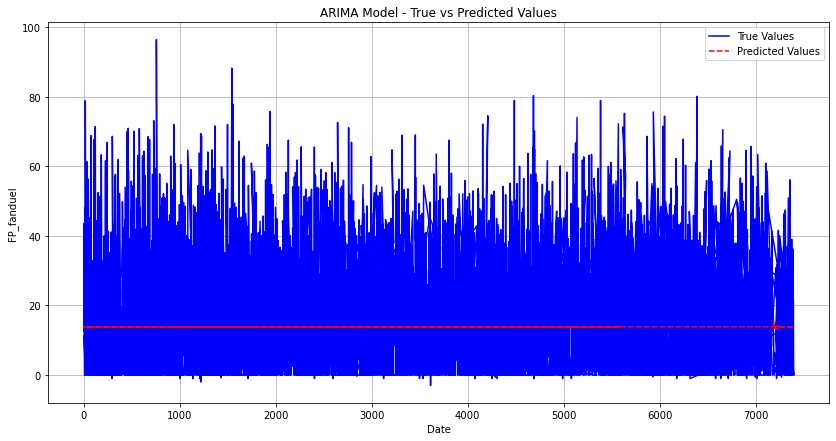

In [9]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

# Sort the data by game_date
dataset = dataset.sort_values('GAME_DATE')

# Split the data into training and testing sets (80% train, 20% test)
train_size = int(len(dataset) * 0.8)
train, test = dataset[:train_size], dataset[train_size:]

# Extract the target variable
y_train = train['FP_fanduel']
y_test = test['FP_fanduel']

# Fit an ARIMA model
model = ARIMA(y_train, order=(5, 1, 0))
model_fit = model.fit()

# Make predictions
y_pred = model_fit.forecast(steps=len(test))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'RMSE: {rmse}')

# Plotting the true values and predictions
plt.figure(figsize=(14, 7))
plt.plot(test.index, y_test, label='True Values', color='blue')
plt.plot(test.index, y_pred, label='Predicted Values', color='red', linestyle='--')
plt.title('ARIMA Model - True vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('FP_fanduel')
plt.legend()
plt.grid(True)
plt.show()